# RAVDESS Speech Emotion Recognition

In [70]:
import constants as const
import utils
import utils_audio as ut_au
from pathlib import Path
import matplotlib.pyplot as plt
import IPython.display as ipd
import logging
import numpy as np
import seaborn as sns
import librosa
import librosa.display
import progressbar as pb
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
Input, Conv2D, MaxPooling2D, Dropout,
Dense, Flatten, Resizing, Normalization
)
# from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, Concatenate
from tensorflow.keras.models import Model

import tensorflow as tf
import time
# import scipy
import csv
# import soundfile as snd
import re

In [3]:
from reload import reload_module
reload_module(ut_au)

Module <module 'utils_audio' from 'C:\\Users\\mic-c\\Documents\\GitHubRepo\\CNN-emotion-recognition\\utils_audio.py'> reloaded


In [4]:
SAMPLE_RATE = const.RAVDESS_SAMPLE_RATE
EMOTIONS_LABELS = const.EMOTIONS_LABELS
NUM_CLASSES = const.DATASET_NUM_CLASSES

In [5]:
# Set the SEED value for experiment reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [6]:
log_file = Path(const.logs_path, 'SPEER.log')
logging.basicConfig(
    format='%(asctime)s %(message)s',
    filemode='a',
    filename=log_file,
    encoding='utf-8',
    level=logging.INFO,
    force=True
)

In [18]:
DATASET_PATH = const.trim_audios_path
ORIGINAL_DATASET_PATH = const.audios_dataset_path
CHUNKED_DATASET_PATH = const.chunked_audios_path

data_dir = Path(DATASET_PATH)
chunks_type = '1s_250ms'
chunked_data_dir = Path(CHUNKED_DATASET_PATH, chunks_type)
original_data_dir = Path(ORIGINAL_DATASET_PATH)

label_names = const.EMOTIONS_LABELS_SORTED

In [20]:
chunk_parts = Path(chunks_type).name.split('_')
re_frame_len = int(re.search(r'(\d+)', chunk_parts[0]).group())
re_frame_len = re_frame_len if re_frame_len < 10 else re_frame_len / 1000
re_hop_len = int(re.search(r'(\d+)', chunk_parts[1]).group())
re_hop_len = re_hop_len if re_hop_len < 10 else re_hop_len / 1000

frame_len = int(SAMPLE_RATE * re_frame_len)
hop_len = int(SAMPLE_RATE * re_hop_len)

In [21]:
frame_len, hop_len

(48000, 12000)

## Exploration of speech files

### Create file structure based on emotion

The dataset's audio clips are stored in eight folders corresponding to each speech command: `neutral`, `calm`, `happy`, `sad`, `angry`, `fearful`, `disgust`, `surprised`:

In [10]:
# List all filesname

original_file_list = [str(x) for x in original_data_dir.glob('*/*')]

### Reading Audios Length

In [11]:
# Read saved lengths
original_sampled_length = np.genfromtxt(
    Path(const.csv_path, 'original_audios_length.csv'),
    delimiter=',', dtype=int
)

Print some statistics about audios

Consider a trim for the audios, to have the same lengths. 

We know that usually (by observed audio/video) :
- the start of the speech is one second (SAMPLE_RATE * 1) after the beginning of the audio
- the end of the speech is one second (SAMPLE_RATE * 1) before the end of the audio 

So, to have a certain margin of error, we decided to cut:
- 4/5 (80 %) of SAMPLE RATE
- audio_length - ( 4/5 of SAMPLE RATE )

After this phase, the silenced part will be trimmed.
BUT, audio will continue to have different length.
So an additional preprocessing phase is needed.

In [12]:
trimmed_length = np.genfromtxt(
    Path(const.csv_path, 'audios_length.csv'),
    delimiter=',', dtype=int
)

In [13]:
# Classify audio length in classes of length
categories = [0]
categories = np.append(
    categories,
    np.arange(SAMPLE_RATE, SAMPLE_RATE * 4 + 1, SAMPLE_RATE / 2, dtype=int)
)

categories_labels = [
    '< 1s', '1 - 1.5', '1.5 - 2', '2 - 2.5',
    '2.5 - 3', '3 - 3.5', '3.5 - 4', '>4'
]
temp = [0] * categories.shape[0]

for x in trimmed_length:
    if x < categories[1]:  # <1s
        temp[0] += 1
    elif x <= categories[2]:  # 1-1.5
        temp[1] += 1
    elif x <= categories[3]:  # 1.5-2
        temp[2] += 1
    elif x <= categories[4]:  # 2-2.5
        temp[3] += 1
    elif x <= categories[5]:  # 2.5-3
        temp[4] += 1
    elif x <= categories[6]:  # 3-3.5
        temp[5] += 1
    elif x <= categories[7]:  # 3.5-4
        temp[6] += 1
    else:                     # >4s
        temp[7] += 1

Total audios: 1440


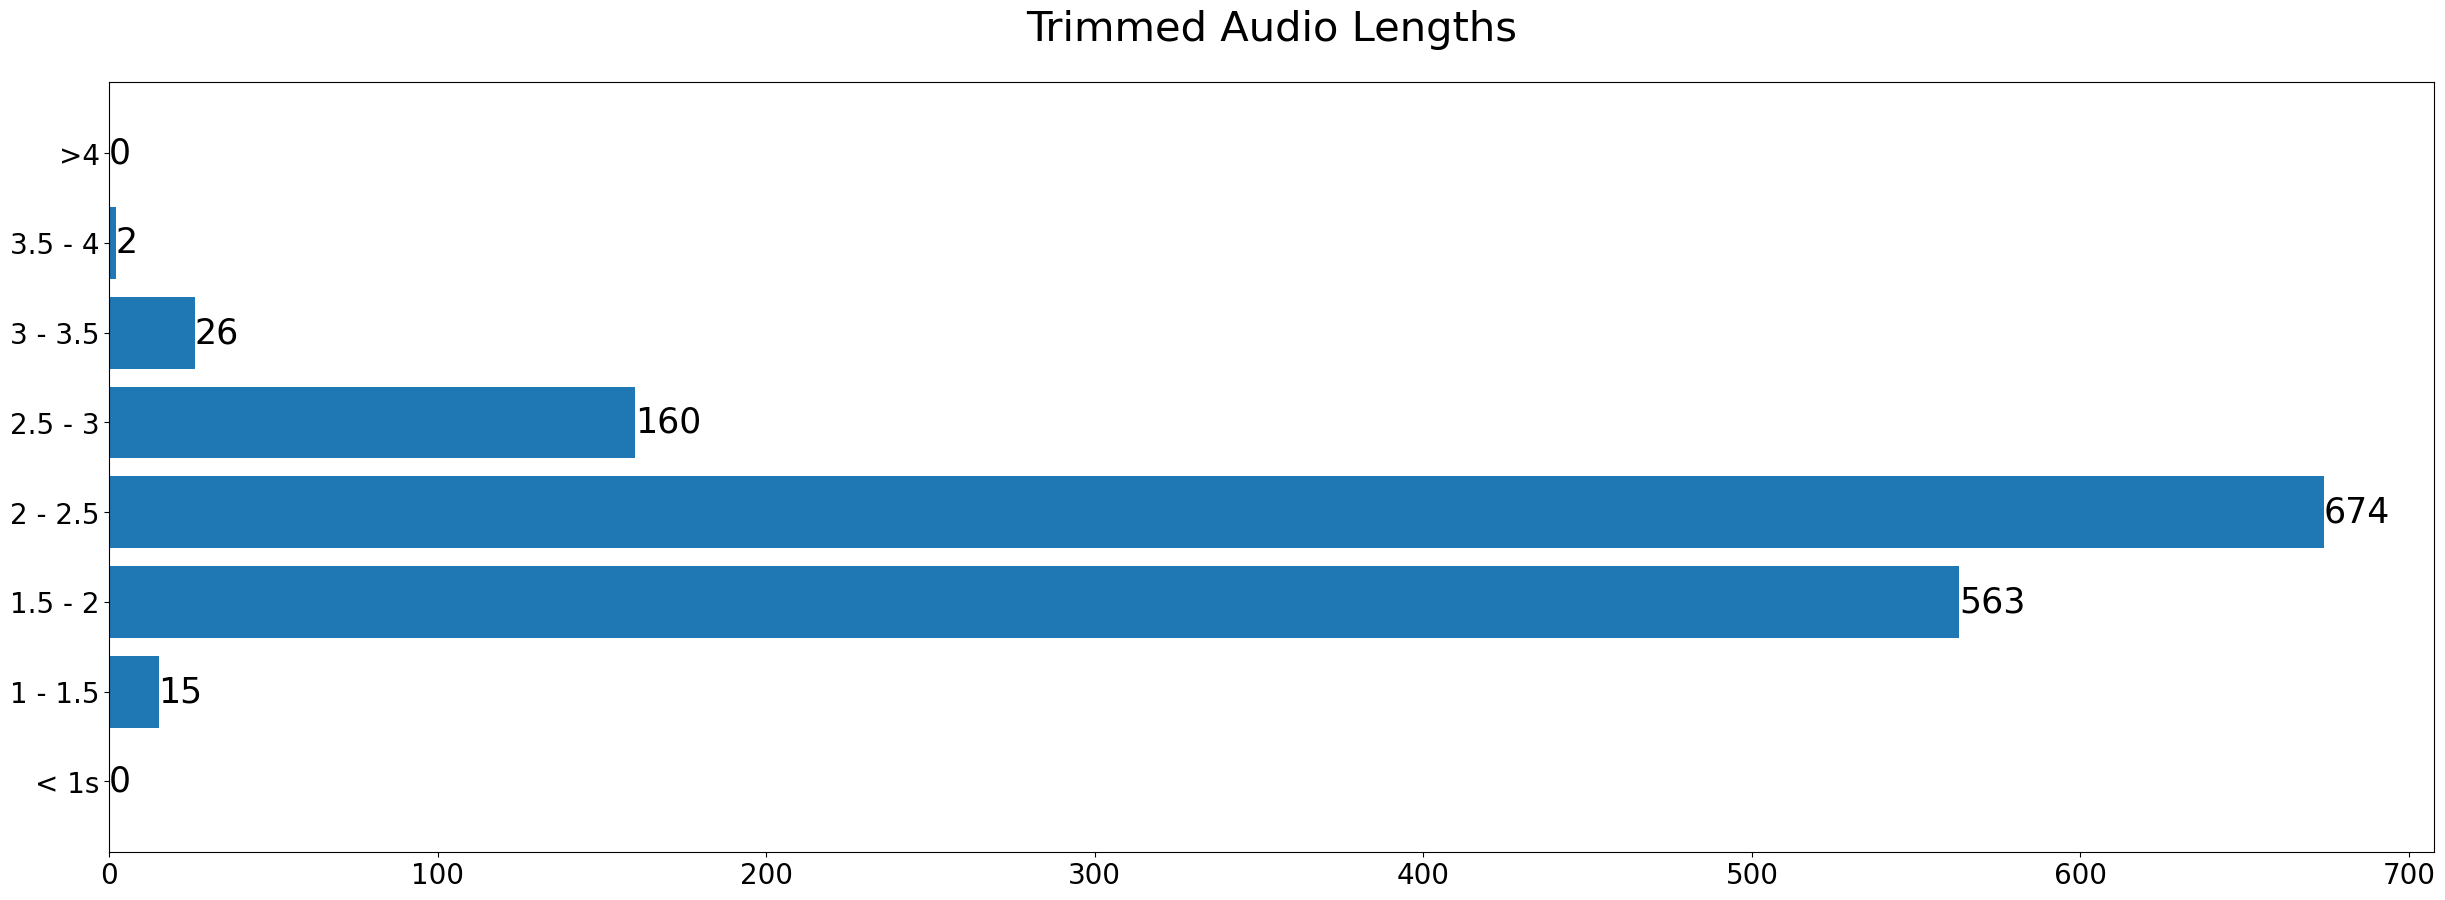

In [14]:
print(f'Total audios: {len(trimmed_length)}')
fig = plt.figure(figsize=(30, 10))
bar_plot = plt.barh(categories_labels, temp)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylabel('Numero immagini', fontsize=25, labelpad=20)
# plt.xlabel('Classi distribuzione errori',fontsize=25, labelpad=20)
plt.title('Trimmed Audio Lengths', fontsize=30, pad=30)
plt.bar_label(bar_plot, fontsize=25)
plt.show()


In [15]:
chunk_files = [str(x) for x in Path(chunked_data_dir).glob('*/*.wav')]
TOTAL_CHUNKS = len(chunk_files)
TOTAL_CHUNKS

7086

## Data Augmentation ??

## DATASET CREATION AND TRAINING

Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

In [16]:
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
# # Padded Audio
# SEQUENCE_LENGTH = 176253  # max
# TOTAL_ELEMENTS = 1440

# Chunked Audio
SEQUENCE_LENGTH = frame_len
TOTAL_ELEMENTS = TOTAL_CHUNKS

In [22]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=chunked_data_dir,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    seed=SEED,
    output_sequence_length=SEQUENCE_LENGTH,
    subset='both'
)


print(f'Label names: {label_names}')

Found 7086 files belonging to 8 classes.
Using 5669 files for training.
Using 1417 files for validation.
Label names: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [23]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [24]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to **split the validation set into two halves**. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [25]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [100]:
train_ds_elements = (len(train_ds) * BATCH_SIZE)
test_ds_elements = (len(test_ds) * BATCH_SIZE)
val_ds_elements = (len(val_ds) * BATCH_SIZE)

In [102]:
print(f'train_ds samples: {train_ds_elements}')
print(f'test_ds samples: {test_ds_elements}')
print(f'val_ds samples: {val_ds_elements}')

train_ds samples: 5696
test_ds samples: 768
val_ds samples: 704


In [28]:
for ex_audio, example_labels in train_ds.take(1):
    print(ex_audio.shape)
    print(example_labels.shape)

(64, 48000)
(64,)


Let's plot a few audio waveforms:

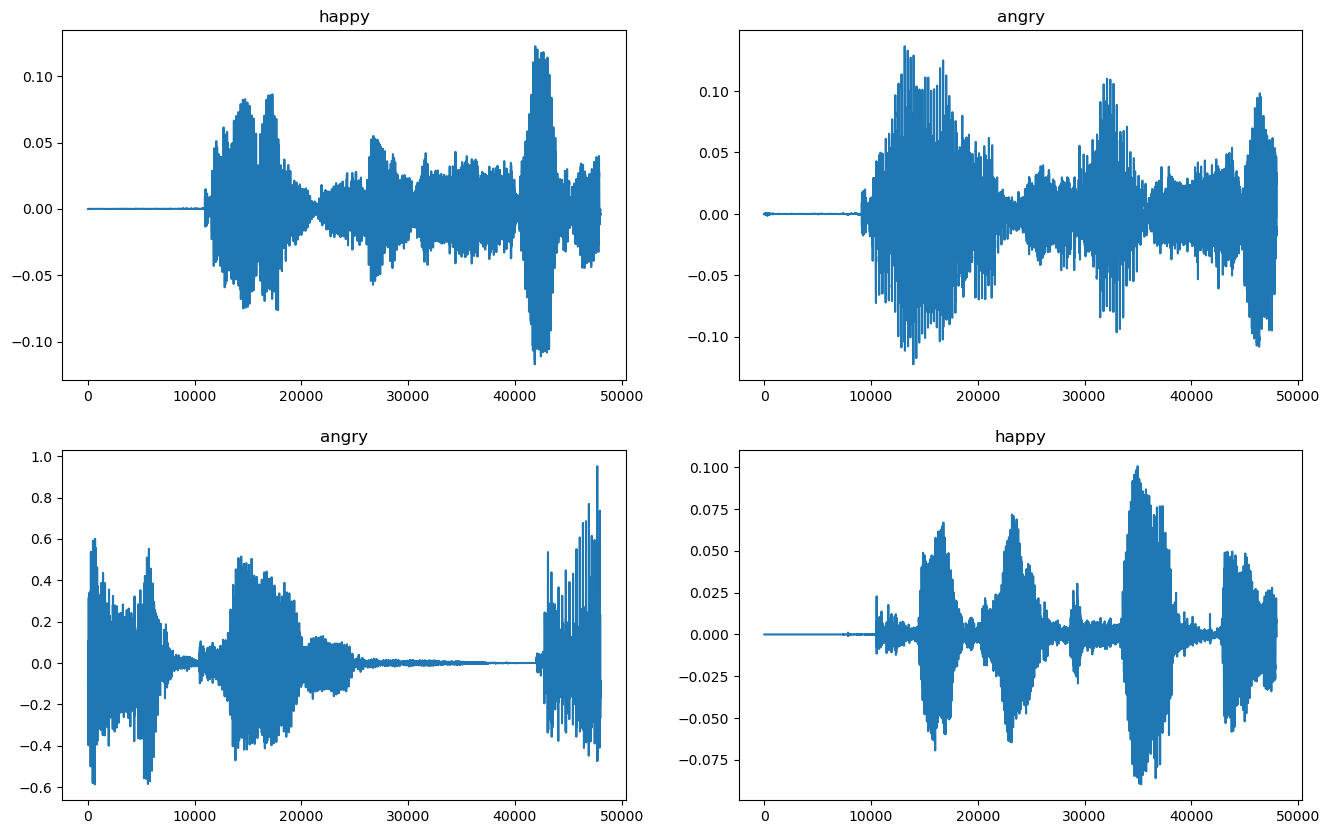

In [29]:
plt.figure(figsize=(16, 10))
rows = 2
cols = 2
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    audio_signal = ex_audio[i]

    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    # plt.yticks(np.arange(-1.2, 1.2, 0.2))
    # plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [30]:
# FRAME_LENGTH = FFT_LENGTH = 2048  # Windows size
# FRAME_STEP = 512
# N_MELS = 128
# N_MFCC = 30

In [31]:
ut_au.calc_spec_shape(samples=SAMPLE_RATE)

Simulating shapes and info ...
Win size is 426 ms, sliding to right 106 ms
Spectrogram shape:(1025, 90)  [frequency_bins, frames]
Mel Spectrogram shape:(128, 90)  [n_mels, frames]
MFCC shape:(30, 90)  [n_mfcc, frames]


Now, create spectrogram datasets from the audio datasets:

In [32]:
train_spectrogram_ds = ut_au.make_spec_ds(train_ds)
# train_spectrogram_ds_original = make_spec_ds_original(train_ds)
val_spectrogram_ds = ut_au.make_spec_ds(val_ds)
test_spectrogram_ds = ut_au.make_spec_ds(test_ds)

Out:  (None, 90, 128, 1)
Out:  (None, 90, 128, 1)
Out:  (None, 90, 128, 1)


In [33]:
train_spectrogram_ds.element_spec

(TensorSpec(shape=(None, 48000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 90, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Examine the spectrograms for different examples of the dataset:

In [34]:
for ex_audio, ex_spectrograms, ex_labels in train_spectrogram_ds.take(1):
    break

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

Spec type: <class 'numpy.ndarray'>
Spec shape: (90, 128, 1)
Label: 3 = fearful


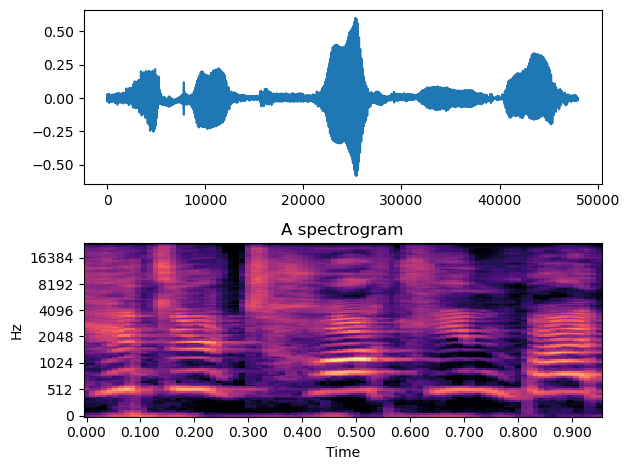

In [35]:
gen = np.random.default_rng()
idx = gen.integers(0, len(ex_audio))

audio = ex_audio[idx]
spectrogram = ex_spectrograms[idx]
label = ex_labels[idx]

print(f'Spec type: {type(spectrogram.numpy())}')
print(f'Spec shape: {spectrogram.shape}')
print(f'Label: {label} = {label_names[label]}')
# ipd.display(ipd.Audio(audio, rate=SAMPLE_RATE))

fig, ax = plt.subplots(2)

# utils.show_waveform(audio)
timescale = np.arange(audio.shape[0])
ax[0].plot(timescale, audio.numpy())
# ax[0].set_xlim([0, 16000])

s = utils.squeeze_np_array(spectrogram.numpy())
s = s.T

ut_au.plot_librosa_spectrogram(s, ax[1], y_axis='mel')
plt.tight_layout()
plt.show()

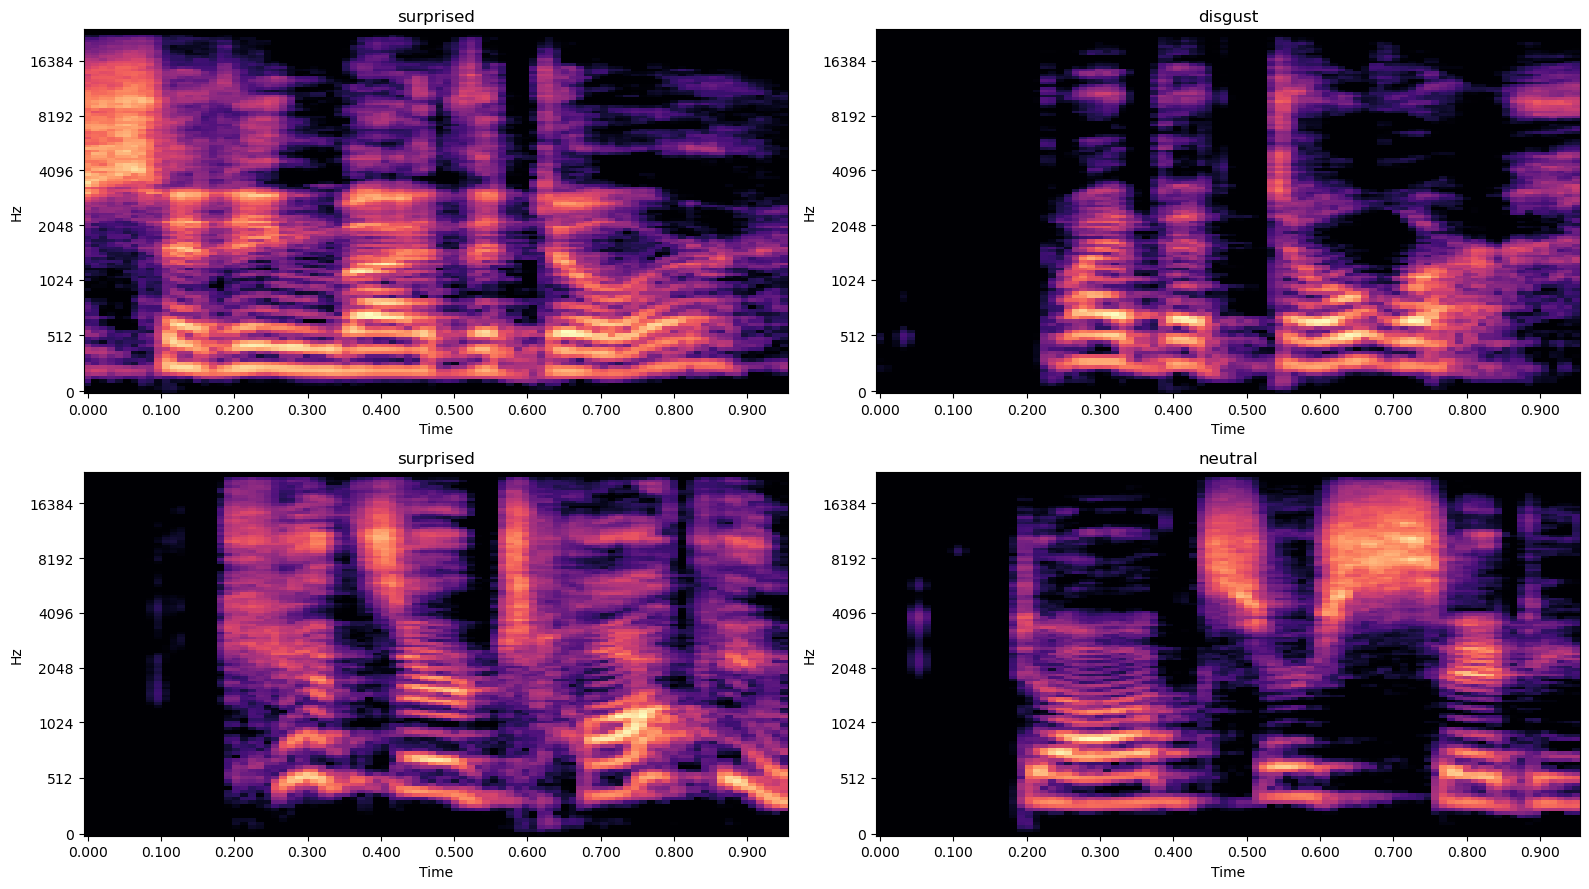

In [36]:
rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    s = utils.squeeze_np_array(ex_spectrograms[i].numpy())
    s = s.T
    ut_au.plot_librosa_spectrogram(s, ax, y_axis='mel')
    ax.set_title(label_names[ex_labels[i].numpy()])

plt.tight_layout()
plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [62]:
train_spectrogram_ds = (
    train_spectrogram_ds
    .cache()
    # .shuffle(10000)
    .prefetch(tf.data.AUTOTUNE)
)

val_spectrogram_ds = (
    val_spectrogram_ds
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

test_spectrogram_ds = (
    test_spectrogram_ds
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [63]:
print(f'''
Train Spectrogram Dataset
type: {type(train_spectrogram_ds)}
element_spec: {train_spectrogram_ds.element_spec}

Example_spectrogram
type:{type(ex_spectrograms)}
shape{ex_spectrograms.shape}
''')


Train Spectrogram Dataset
type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
element_spec: (TensorSpec(shape=(None, 48000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 90, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Example_spectrogram
type:<class 'tensorflow.python.framework.ops.EagerTensor'>
shape(64, 90, 128, 1)



In [65]:
def speech_model(name='speech_model'):

    input_shape = ex_spectrograms.shape[1:]
    print('Input shape:', input_shape)

    dropout_1 = 0.25
    dropout_2 = 0.5

    norm_layer = Normalization(name='Normalization')
    norm_layer.adapt(
        data=train_spectrogram_ds.map(map_func=lambda audio, spec, label: spec)
    )

    inputs = Input(shape=input_shape, name='Input')
    resizing = Resizing(64, 64, crop_to_aspect_ratio=True, name='Resizing')(inputs)
    normalize = norm_layer(resizing)
    conv1 = Conv2D(32, 3, activation='relu', name='Conv2D_1')(normalize)
    conv2 = Conv2D(64, 3, activation='relu', name='Conv2D_2')(conv1)
    pool1 = MaxPooling2D(name='MaxPooling2D')(conv2)
    dropout1 = Dropout(dropout_1, name=f'Dropout_{dropout_1}')(pool1)
    flatten = Flatten(name='Flatten')(dropout1)
    dense1 = Dense(128, activation='relu', name='Dense_1')(flatten)
    dropout2 = Dropout(dropout_2, name=f'Dropout_{dropout_2}')(dense1)
    output = Dense(NUM_CLASSES, name='Output', activation='softmax')(dropout2)

    model = Model(inputs, output)
    model._name = name

    return model

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [66]:
tf.keras.backend.clear_session()

In [71]:
# model = tensorflow_tutorial_model('tensorflow_tutorial_model')

model = None
model = speech_model()
model.summary()

Input shape: (90, 128, 1)
Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90, 128, 1)]      0         
                                                                 
 Resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 Normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 Conv2D_1 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 Conv2D_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 MaxPooling2D (MaxPooling2D)  (None, 30, 30, 64)       0         
                            

In [76]:
# Define training callbacks
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    verbose=1, patience=5, restore_best_weights=True
)

In [77]:
METRICS = ['accuracy']

In [78]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

Train the model:

In [79]:
EPOCHS = 100
time_callback = TimeHistory()
history = model.fit(
    train_spectrogram_ds.map(
        map_func=lambda audio, spec, label: [spec, label]
    ),
    validation_data=val_spectrogram_ds.map(
        map_func=lambda audio, spec, label: [spec, label]
    ),
    epochs=EPOCHS,
    callbacks=[time_callback, early_stopping_callback],
    use_multiprocessing=True
)

Epoch 1/100
89/89 [==============================] - 268s 802ms/step - loss: 1.9243 - accuracy: 0.2768 - val_loss: 1.8438 - val_accuracy: 0.2841
Epoch 2/100
89/89 [==============================] - 24s 248ms/step - loss: 1.7473 - accuracy: 0.3216 - val_loss: 1.7378 - val_accuracy: 0.3011
Epoch 3/100
89/89 [==============================] - 22s 248ms/step - loss: 1.6288 - accuracy: 0.3805 - val_loss: 1.6960 - val_accuracy: 0.3452
Epoch 4/100
89/89 [==============================] - 22s 250ms/step - loss: 1.5042 - accuracy: 0.4239 - val_loss: 1.6976 - val_accuracy: 0.3438
Epoch 5/100
89/89 [==============================] - 22s 248ms/step - loss: 1.3657 - accuracy: 0.4793 - val_loss: 1.7291 - val_accuracy: 0.3551
Epoch 6/100
89/89 [==============================] - 22s 248ms/step - loss: 1.1796 - accuracy: 0.5569 - val_loss: 1.6026 - val_accuracy: 0.4048
Epoch 7/100
89/89 [==============================] - 22s 248ms/step - loss: 1.0504 - accuracy: 0.6035 - val_loss: 1.5719 - val_accuracy

 99/100 [============================>.] - ETA: 0s - loss: 0.6281 - accuracy: 0.7757

100/100 [==============================] - 1s 8ms/step - loss: 0.6291 - accuracy: 0.7756 - val_loss: 0.6382 - val_accuracy: 0.8034


Epoch 6/10


  1/100 [..............................] - ETA: 0s - loss: 0.6006 - accuracy: 0.8281

  8/100 [=>............................] - ETA: 0s - loss: 0.5532 - accuracy: 0.8223

 15/100 [===>..........................] - ETA: 0s - loss: 0.5485 - accuracy: 0.8188

 22/100 [=====>........................] - ETA: 0s - loss: 0.5730 - accuracy: 0.8047

 29/100 [=======>......................] - ETA: 0s - loss: 0.5788 - accuracy: 0.8001

 36/100 [=========>....................] - ETA: 0s - loss: 0.5725 - accuracy: 0.8012

 43/100 [===========>..................] - ETA: 0s - loss: 0.5849 - accuracy: 0.7991

 50/100 [==============>...............] - ETA: 0s - loss: 0.5769 - accuracy: 0.7997

 57/100 [================>.............] - ETA: 0s - loss: 0.5663 - accuracy: 0.8007

 64/100 [==================>...........] - ETA: 0s - loss: 0.5643 - accuracy: 0.8005

 71/100 [====================>.........] - ETA: 0s - loss: 0.5627 - accuracy: 0.8017

 78/100 [======================>.......] - ETA: 0s - loss: 0.5565 - accuracy: 0.8041

 85/100 [========================>.....] - ETA: 0s - loss: 0.5563 - accuracy: 0.8040

 92/100 [==========================>...] - ETA: 0s - loss: 0.5543 - accuracy: 0.8038

 99/100 [============================>.] - ETA: 0s - loss: 0.5524 - accuracy: 0.8043

100/100 [==============================] - 1s 8ms/step - loss: 0.5495 - accuracy: 0.8056 - val_loss: 0.5947 - val_accuracy: 0.7982


Epoch 7/10


  1/100 [..............................] - ETA: 0s - loss: 0.4388 - accuracy: 0.8594

  8/100 [=>............................] - ETA: 0s - loss: 0.5070 - accuracy: 0.8105

 15/100 [===>..........................] - ETA: 0s - loss: 0.5234 - accuracy: 0.8125

 22/100 [=====>........................] - ETA: 0s - loss: 0.5107 - accuracy: 0.8239

 29/100 [=======>......................] - ETA: 0s - loss: 0.5093 - accuracy: 0.8233

 36/100 [=========>....................] - ETA: 0s - loss: 0.5090 - accuracy: 0.8242

 43/100 [===========>..................] - ETA: 0s - loss: 0.5035 - accuracy: 0.8241

 50/100 [==============>...............] - ETA: 0s - loss: 0.5036 - accuracy: 0.8222

 57/100 [================>.............] - ETA: 0s - loss: 0.4962 - accuracy: 0.8259

 64/100 [==================>...........] - ETA: 0s - loss: 0.4966 - accuracy: 0.8254

 71/100 [====================>.........] - ETA: 0s - loss: 0.4951 - accuracy: 0.8270

 78/100 [======================>.......] - ETA: 0s - loss: 0.4976 - accuracy: 0.8249

 85/100 [========================>.....] - ETA: 0s - loss: 0.5019 - accuracy: 0.8226

 92/100 [==========================>...] - ETA: 0s - loss: 0.5020 - accuracy: 0.8225

 99/100 [============================>.] - ETA: 0s - loss: 0.5064 - accuracy: 0.8207

100/100 [==============================] - 1s 8ms/step - loss: 0.5055 - accuracy: 0.8213 - val_loss: 0.5552 - val_accuracy: 0.8281


Epoch 8/10


  1/100 [..............................] - ETA: 0s - loss: 0.4320 - accuracy: 0.8594

  8/100 [=>............................] - ETA: 0s - loss: 0.4120 - accuracy: 0.8672

 15/100 [===>..........................] - ETA: 0s - loss: 0.4024 - accuracy: 0.8604

 22/100 [=====>........................] - ETA: 0s - loss: 0.4150 - accuracy: 0.8537

 29/100 [=======>......................] - ETA: 0s - loss: 0.4301 - accuracy: 0.8475

 37/100 [==========>...................] - ETA: 0s - loss: 0.4501 - accuracy: 0.8383

 44/100 [============>.................] - ETA: 0s - loss: 0.4487 - accuracy: 0.8398

 51/100 [==============>...............] - ETA: 0s - loss: 0.4461 - accuracy: 0.8416

 58/100 [================>.............] - ETA: 0s - loss: 0.4432 - accuracy: 0.8440

 65/100 [==================>...........] - ETA: 0s - loss: 0.4386 - accuracy: 0.8462

 72/100 [====================>.........] - ETA: 0s - loss: 0.4419 - accuracy: 0.8459

 79/100 [======================>.......] - ETA: 0s - loss: 0.4436 - accuracy: 0.8453

 86/100 [========================>.....] - ETA: 0s - loss: 0.4411 - accuracy: 0.8470

 93/100 [==========================>...] - ETA: 0s - loss: 0.4411 - accuracy: 0.8468

100/100 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.8461

100/100 [==============================] - 1s 8ms/step - loss: 0.4423 - accuracy: 0.8461 - val_loss: 0.5224 - val_accuracy: 0.8411


Epoch 9/10


  1/100 [..............................] - ETA: 0s - loss: 0.3651 - accuracy: 0.8594

  8/100 [=>............................] - ETA: 0s - loss: 0.3892 - accuracy: 0.8516

 15/100 [===>..........................] - ETA: 0s - loss: 0.3717 - accuracy: 0.8677

 22/100 [=====>........................] - ETA: 0s - loss: 0.3885 - accuracy: 0.8594

 29/100 [=======>......................] - ETA: 0s - loss: 0.3888 - accuracy: 0.8642

 36/100 [=========>....................] - ETA: 0s - loss: 0.3956 - accuracy: 0.8620

 43/100 [===========>..................] - ETA: 0s - loss: 0.4074 - accuracy: 0.8583

 50/100 [==============>...............] - ETA: 0s - loss: 0.4031 - accuracy: 0.8597

 57/100 [================>.............] - ETA: 0s - loss: 0.4106 - accuracy: 0.8555

 64/100 [==================>...........] - ETA: 0s - loss: 0.4102 - accuracy: 0.8572

 71/100 [====================>.........] - ETA: 0s - loss: 0.4063 - accuracy: 0.8583

 78/100 [======================>.......] - ETA: 0s - loss: 0.4075 - accuracy: 0.8586

 85/100 [========================>.....] - ETA: 0s - loss: 0.4084 - accuracy: 0.8572

 92/100 [==========================>...] - ETA: 0s - loss: 0.4074 - accuracy: 0.8572

 99/100 [============================>.] - ETA: 0s - loss: 0.4062 - accuracy: 0.8580

100/100 [==============================] - 1s 8ms/step - loss: 0.4088 - accuracy: 0.8572 - val_loss: 0.4882 - val_accuracy: 0.8464


Epoch 10/10


  1/100 [..............................] - ETA: 0s - loss: 0.4479 - accuracy: 0.8438

  8/100 [=>............................] - ETA: 0s - loss: 0.3259 - accuracy: 0.8750

 15/100 [===>..........................] - ETA: 0s - loss: 0.3298 - accuracy: 0.8708

 22/100 [=====>........................] - ETA: 0s - loss: 0.3435 - accuracy: 0.8750

 29/100 [=======>......................] - ETA: 0s - loss: 0.3379 - accuracy: 0.8772

 36/100 [=========>....................] - ETA: 0s - loss: 0.3405 - accuracy: 0.8789

 43/100 [===========>..................] - ETA: 0s - loss: 0.3433 - accuracy: 0.8783

 50/100 [==============>...............] - ETA: 0s - loss: 0.3405 - accuracy: 0.8803

 57/100 [================>.............] - ETA: 0s - loss: 0.3383 - accuracy: 0.8810

 64/100 [==================>...........] - ETA: 0s - loss: 0.3346 - accuracy: 0.8828

 71/100 [====================>.........] - ETA: 0s - loss: 0.3401 - accuracy: 0.8823

 78/100 [======================>.......] - ETA: 0s - loss: 0.3412 - accuracy: 0.8828

 85/100 [========================>.....] - ETA: 0s - loss: 0.3440 - accuracy: 0.8811

 92/100 [==========================>...] - ETA: 0s - loss: 0.3473 - accuracy: 0.8786

 99/100 [============================>.] - ETA: 0s - loss: 0.3489 - accuracy: 0.8788

100/100 [==============================] - 1s 8ms/step - loss: 0.3496 - accuracy: 0.8786 - val_loss: 0.4704 - val_accuracy: 0.8529


Let's plot the training and validation loss curves to check how your model has improved during training:

In [82]:
EPOCHS = len(time_callback.times)

In [84]:
# epoch training times
print(time_callback.times)

[267.44824719429016, 23.525293827056885, 22.009197235107422, 22.236340522766113, 22.065552949905396, 22.007340669631958, 22.048532724380493, 22.12170171737671, 21.92848515510559, 21.95844531059265, 21.96819019317627, 21.949601888656616, 21.935905694961548, 22.0124454498291]


In [90]:
# Create model path
model_path = Path(const.models_path, 'Speech', model._name)
run_folders = list(
    Path(const.models_path, 'Speech', model._name).glob('Run_*')
)

if not run_folders:
    model_path = Path(model_path, 'Run_1')
else:
    last_run = run_folders.pop()
    last_run_idx = Path(last_run).name.split('_')[-1]
    model_path = Path(model_path, f'Run_{int(last_run_idx) + 1}')

model_path.mkdir(parents=True, exist_ok=False)

In [91]:
metrics = history.history

In [92]:
mod_loss = metrics['loss']
mod_val_loss = metrics['val_loss']
mod_accuracy = metrics['accuracy']
mod_val_accuracy = metrics['val_accuracy']
# mod_f1 = metrics['fBeta_score']
# mod_val_f1 = metrics['val_fBeta_score']

mod_mean_loss = np.mean(mod_loss)
mod_mean_val_loss = np.mean(mod_val_loss)
mod_mean_accuracy = np.mean(mod_accuracy)
mod_mean_val_accuracy = np.mean(mod_val_accuracy)
# mod_mean_f1 = np.mean(mod_f1)
# mod_mean_val_f1 = np.mean(mod_val_f1)

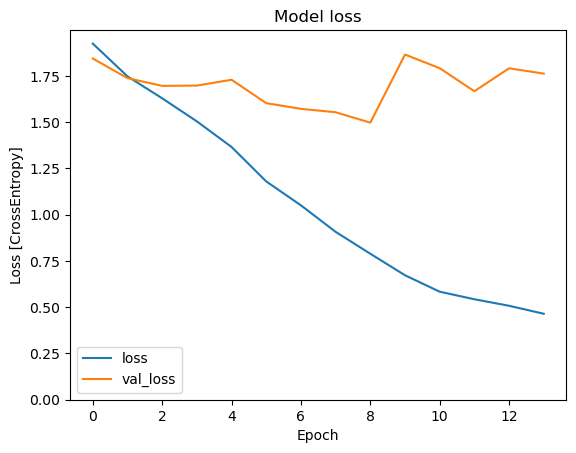

In [93]:
# Save Loss
plt.title('Model loss')
plt.plot(history.epoch, mod_loss, mod_val_loss)
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.savefig(Path(model_path, 'loss.png'))

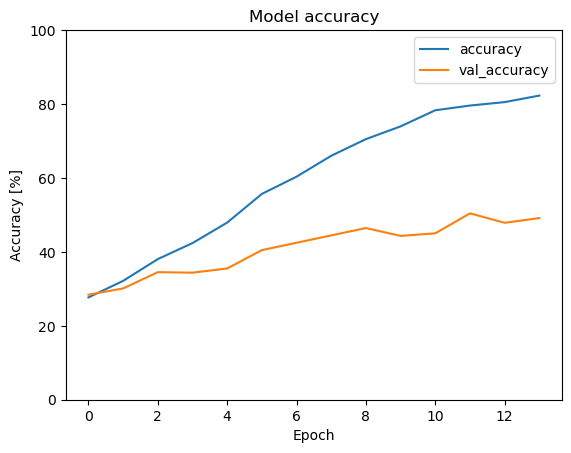

In [94]:
# Save Accuracy
plt.title('Model accuracy')
plt.plot(
    history.epoch,
    100 * np.array(mod_accuracy),
    100 * np.array(mod_val_accuracy)
)
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.savefig(Path(model_path, 'accuracy.png'))

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [95]:
model_eval = model.evaluate(
    test_spectrogram_ds.map(map_func=lambda audio, spec, label: [spec, label]),
    return_dict=True
)

12/12 [==============================] - 28s 2s/step - loss: 1.3819 - accuracy: 0.4965


In [96]:
# Save model
model.save(Path(model_path, f'{model._name}.keras'), overwrite=False)
# Save history
np.save(Path(model_path, f'{model._name}_history.npy'), history)
# Save model image
model_img = tf.keras.utils.plot_model(
    model, Path(model_path, f'{model._name}.png'), show_shapes=True,
    show_layer_names=True, show_layer_activations=True
)

INFO:tensorflow:Assets written to: ram://1f545852-da15-47b4-bc88-446db387bf19/assets


In [97]:
model_eval

{'loss': 1.3819408416748047, 'accuracy': 0.49649369716644287}

In [104]:
test_loss = model_eval['loss']
test_accuracy = model_eval['accuracy']
mean_epoch_time = np.mean(time_callback.times)

In [105]:
# Salvataggio informazioni modello
model_save_path = Path(model_path, f'{model._name}_result.txt')
with open(model_save_path, 'w+', newline='') as res_file:
    res_file.write(f'Dataset path: {chunked_data_dir}\n')
    res_file.write(
        f'(train, val, test):\
        {train_ds_elements, test_ds_elements, val_ds_elements}\n'
    )
    res_file.write(f'Train loss: {str(mod_loss)}\n')
    res_file.write(f'val_loss: {str(mod_val_loss)}\n')
    res_file.write(f'Train accuracy: {str(mod_accuracy)}\n')
    res_file.write(f'Train val_accuracy: {str(mod_val_accuracy)}\n')
    res_file.write(f'Test loss: {str(test_loss)}\n')
    res_file.write(f'Test accuracy: {str(test_accuracy)}\n')
    res_file.write(f'Mean epoch time: {str(mean_epoch_time)}')

In [106]:
# Salvataggio informazioni generali modelli
with open(Path(const.models_path, 'Speech', 'models.csv'), 'a+') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=';', quotechar='|',
                            quoting=csv.QUOTE_MINIMAL)

    # filewriter.writerow([
    #     "Model Name", "Epochs", "% Validation", "% Test set",
    #     "Train loss", "Train accuracy", "Val loss", "Val accuracy",
    #     "Test loss", "Test accuracy", "Mean epoch time", "Note"
    #     ])

    test_ds_perc = utils.trunc((test_ds_elements * 100) / TOTAL_ELEMENTS, 2)
    val_ds_perc = utils.trunc((val_ds_elements * 100) / TOTAL_ELEMENTS, 2)
    full_path = str(Path(model._name, model_path.name))
    filewriter.writerow([
        full_path, EPOCHS, val_ds_perc, test_ds_perc, mod_mean_loss,
        mod_mean_accuracy, mod_mean_val_loss, mod_mean_val_accuracy,
        test_loss, test_accuracy, mean_epoch_time, ''
    ])

In [107]:
for test_audio, test_spectrograms, test_labels in test_spectrogram_ds.take(1):
    print(test_spectrograms.shape)
    print(test_labels.shape)

(64, 90, 128, 1)
(64,)


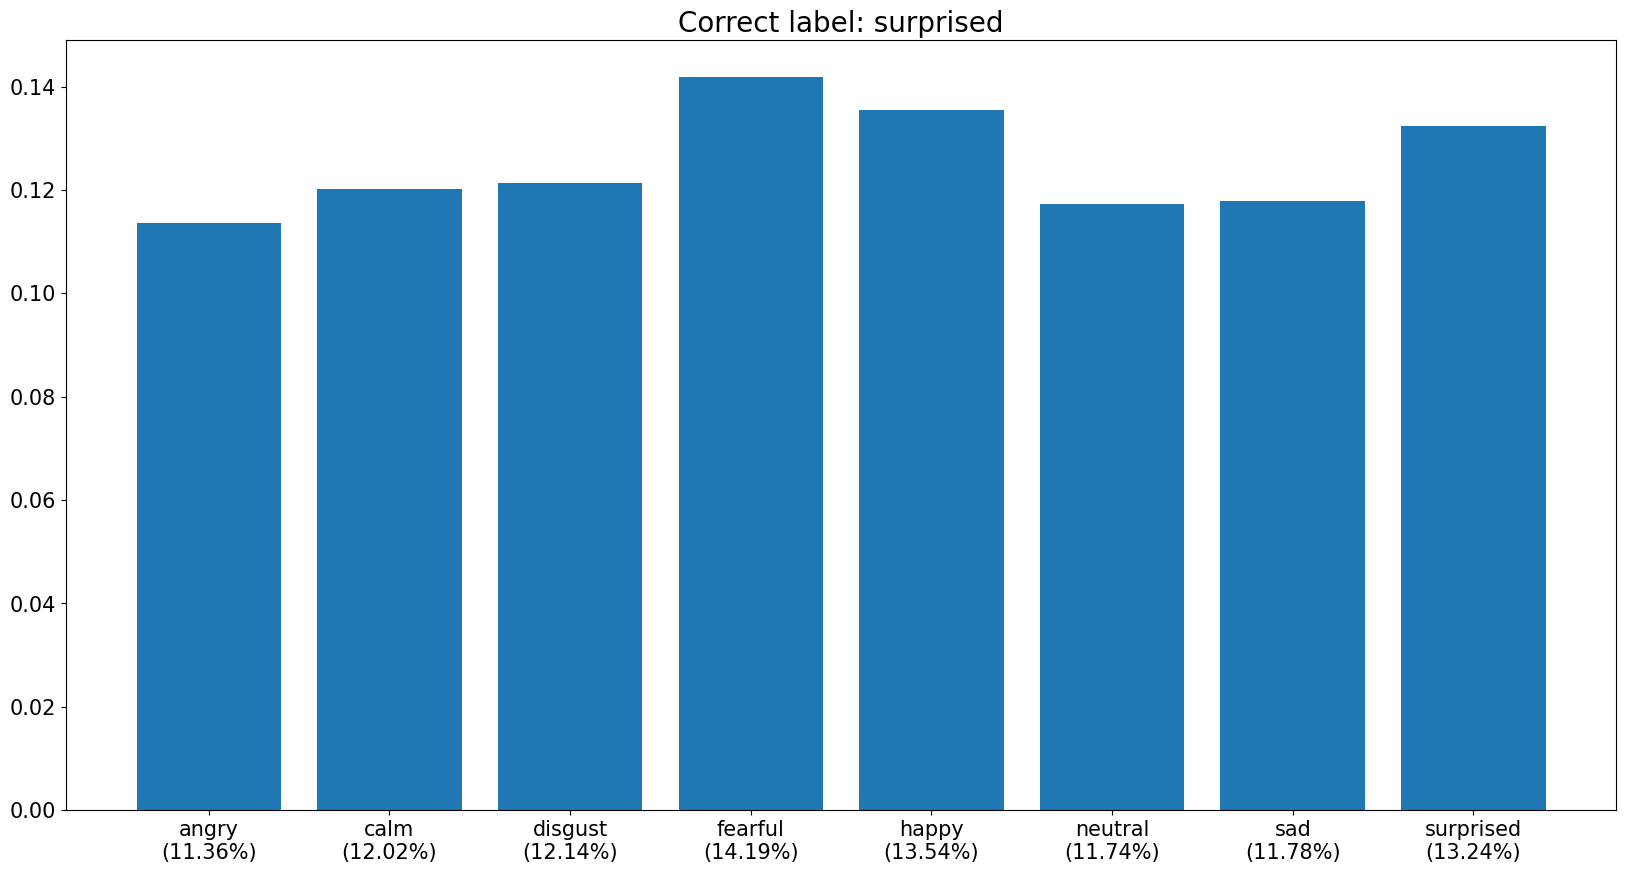

In [108]:
gen = np.random.default_rng(seed=None)
idx = gen.integers(0, len(test_spectrograms))

audio = test_audio[idx]
spec = test_spectrograms[idx]
y = test_labels[idx]

ipd.display(ipd.Audio(audio, rate=SAMPLE_RATE))

spec = utils.extend_tensor(spec, 0)
# spec = spec[np.newaxis, ...]

prediction = model(spec)


# print(f' Label is {label_names[y]}')

pred = tf.nn.softmax(prediction)[0].numpy()
# pred = prediction[0].numpy()

# print([f"{x:.2%}" for x in pred])

valued_arr = []

for idx, name in enumerate(label_names):
    valued_arr.append(f'{name}\n({pred[idx]:.2%})')

fig = plt.figure(figsize=(20, 10))
plt.bar(valued_arr, pred)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {label_names[y]}', fontsize=20)
# plt.xlabel('Predicted class')
# plt.ylabel('Percentage')
plt.show()

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [65]:
y_pred = model.predict(
    test_spectrogram_ds.map(map_func=lambda audio, spec, label: [spec, label])
)

3/3 [==============================] - 0s 20ms/step


In [66]:
y_pred = tf.argmax(y_pred, axis=1)

In [67]:
# TODO: CHECK -- wrong, result is not deterministic
y_true = tf.concat(
    list(test_spectrogram_ds.map(lambda a, s, lab: lab)),
    axis=0
)

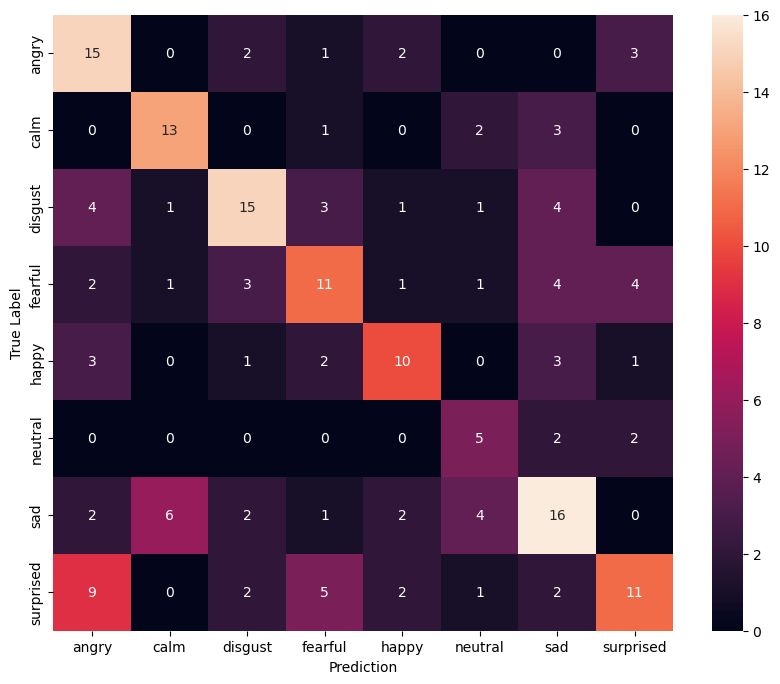

In [68]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.savefig(Path(model_path, f'{model._name}_heat.png'))
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

176253
Out:  (90, 128, 1)
1/1 [==============================] - 1s 1s/step


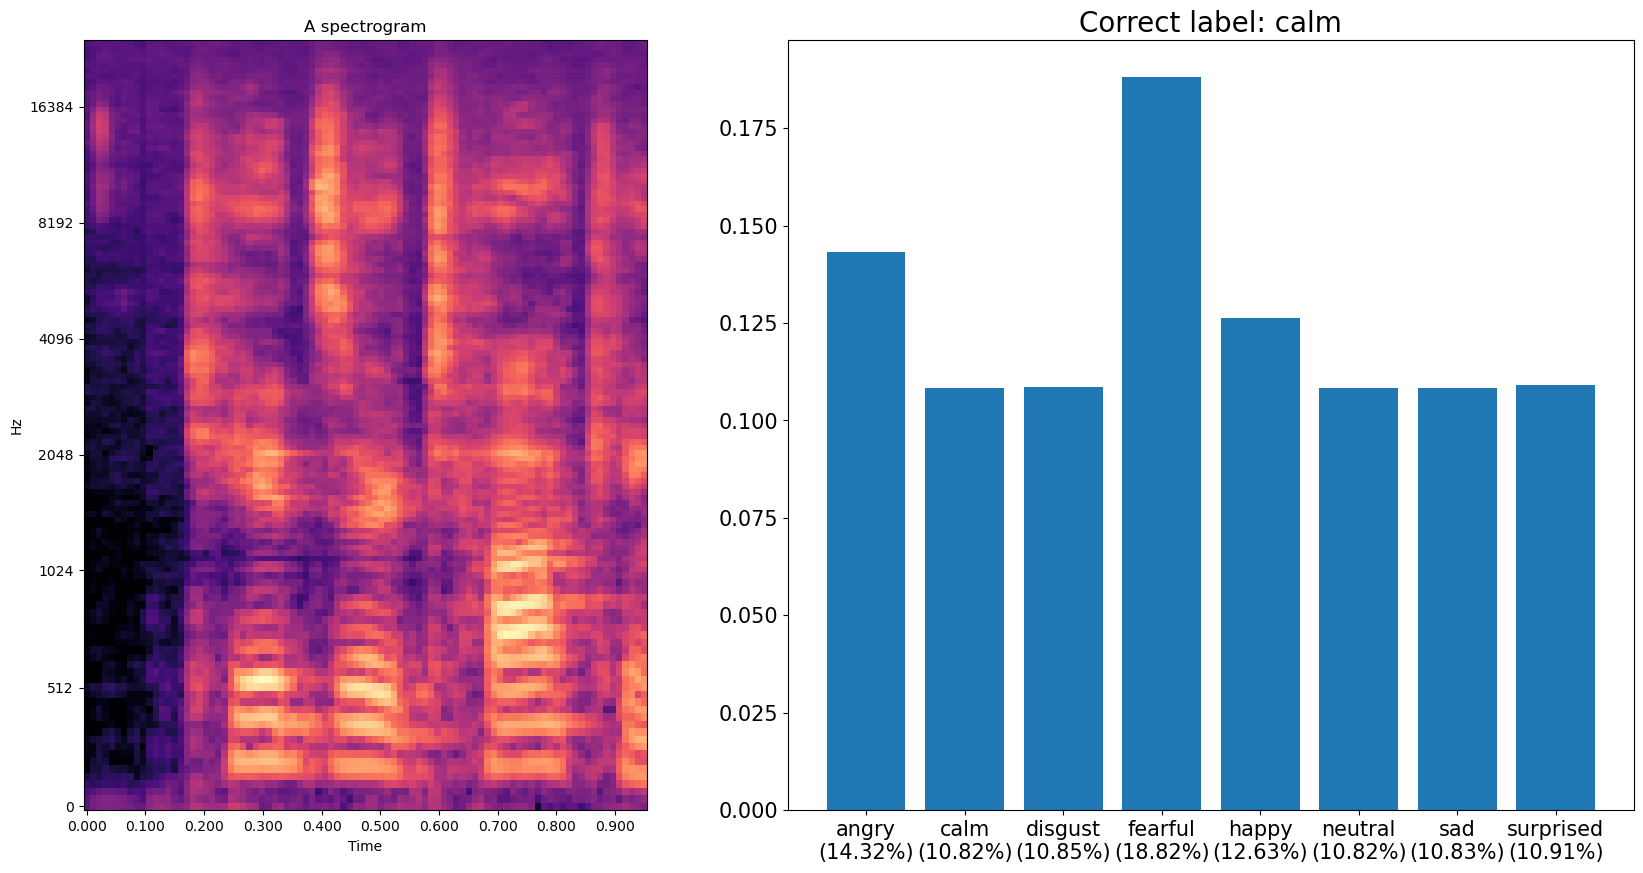

Out:  (90, 128, 1)
1/1 [==============================] - 0s 34ms/step


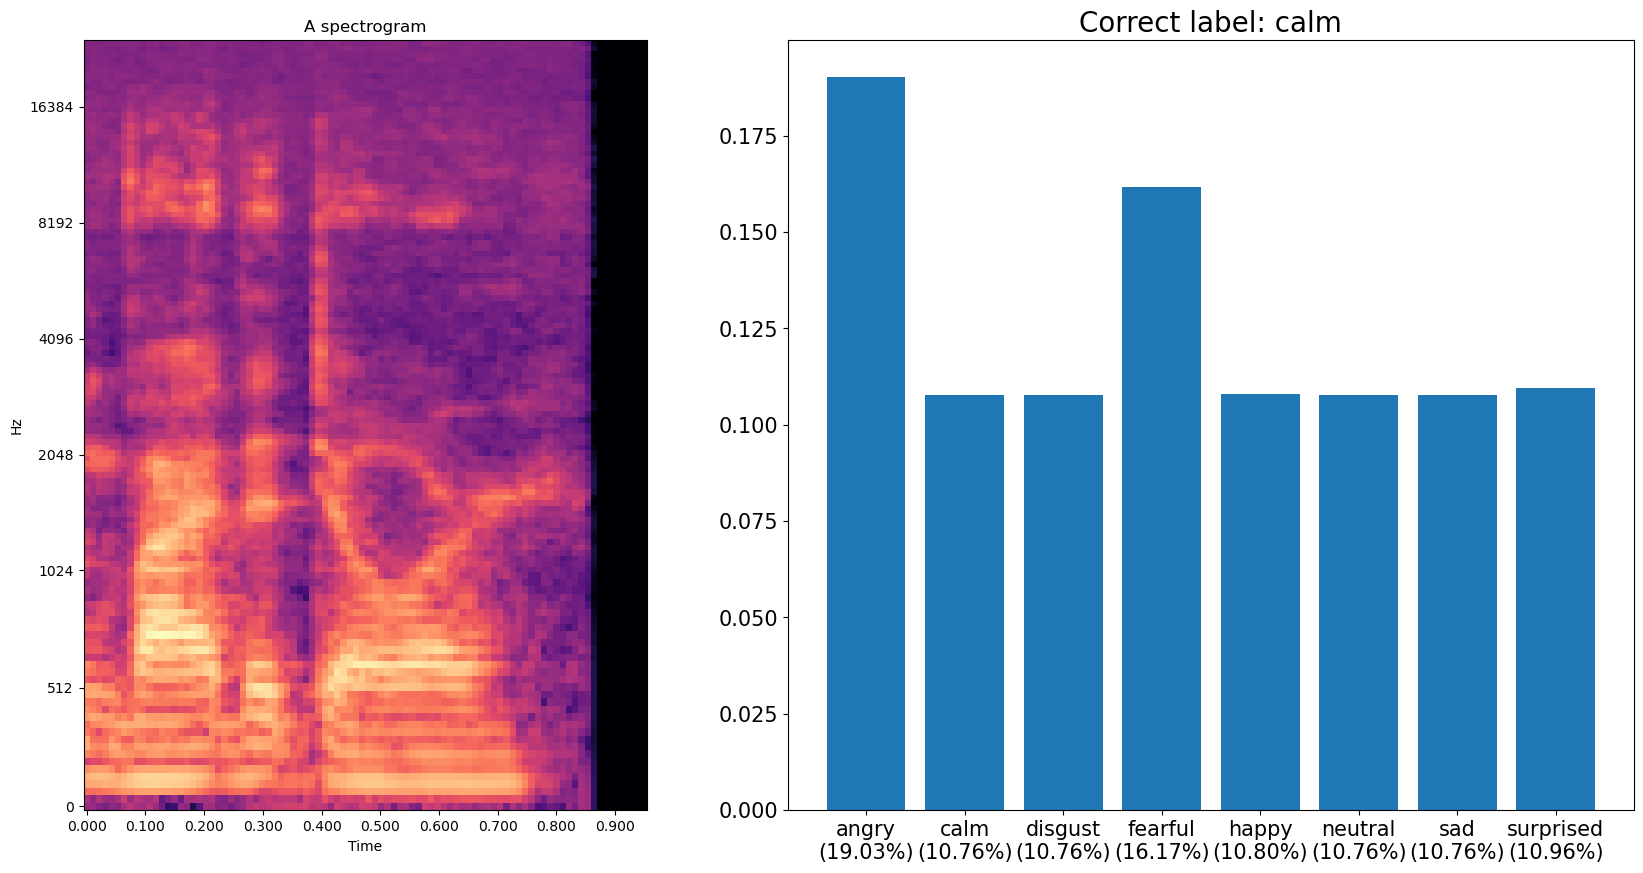

In [109]:
# FULL AUDIO
# path = Path(data_dir, 'angry/03-01-05-01-02-01-04.wav')
path = Path(data_dir, 'calm/03-01-02-01-01-01-07.wav')
# path = Path(data_dir, 'disgust/03-01-07-01-01-02-20.wav')

# path = Path(data_dir, 'fearful/03-01-06-01-01-01-17.wav')
# path = Path(data_dir, 'happy/03-01-03-01-01-01-02.wav')
# path = Path(data_dir, 'neutral/03-01-01-01-02-01-14.wav')
# path = Path(data_dir, 'sad/03-01-04-01-02-02-08.wav')
# path = Path(data_dir, 'surprised/03-01-08-01-01-02-20.wav')

# CHUNKED AUDIO
# path = Path(chunked_data_dir, 'surprised/03-01-08-01-01-01-04-02.wav')


label = path.parent.name

audio_file = tf.io.read_file(str(path))
# audio_file, sample_rate = tf.audio.decode_wav(audio_file, desired_channels=1,
#                                               desired_samples=SEQUENCE_LENGTH)
audio_file, sample_rate = tf.audio.decode_wav(audio_file, desired_channels=1)

# audio_file.shape = (1600,1)

fn_input = utils.squeeze_tensor(audio_file)
print(fn_input.shape[0])

audio_len = fn_input.shape[0]

int_div = int(np.ceil(audio_len / frame_len))
end = int_div * frame_len
if (audio_len < end):
    paddings = [[0, end - audio_len]]
    fn_input = tf.pad(fn_input, paddings, 'CONSTANT', constant_values=0)

audio_len = fn_input.shape[0]

for start in range(0, audio_len, frame_len):
    end = start + frame_len

    chunk = fn_input[start:end]
    pad = np.count_nonzero(chunk == 0, axis=0)
    not_pad = frame_len - pad
    if (pad > not_pad):
        continue

    mel_spec = ut_au.batch_get_tf_mel_spectrogram(chunk, ref='max', batch=False)

    fig, ax = plt.subplots(
        nrows=1, ncols=2, width_ratios=[0.4, 0.6], figsize=(20, 10)
    )
    ut_au.plot_librosa_spectrogram(
        utils.squeeze_np_array(mel_spec.numpy()).T, ax[0],
        y_axis='mel'
    )

    # add a initial axis to shape input for model

    model_input = utils.extend_tensor(mel_spec, 0)

    prediction = model.predict(model_input, batch_size=None)

    pred = tf.nn.softmax(prediction)[0].numpy()

    valued_arr = []

    for idx, name in enumerate(label_names):
        valued_arr.append(f'{name}\n({pred[idx]:.2%})')

    ax[1].bar(valued_arr, pred)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(f'Correct label: {label}', fontsize=20)
    # ax[1].xlabel('Predicted class')
    # ax[1].ylabel('Percentage')
    ipd.display(ipd.Audio(chunk, rate=SAMPLE_RATE))
    plt.show()

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [111]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # You could add additional signatures for a single wave
        # or a ragged-batch.
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, SEQUENCE_LENGTH], dtype=tf.float32)
        )

    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it.
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(
                x, desired_channels=1, desired_samples=SEQUENCE_LENGTH
            )
            x = utils.squeeze_tensor(x)
            x = utils.extend_tensor(x, 0)

        x = ut_au.batch_get_tf_mel_spectrogram(x, ref='max')
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions': result,
                'class_ids': class_ids,
                'class_names': class_names}

Test run the "export" model:

In [112]:
audio_test_path = str(Path(data_dir, 'happy/03-01-03-01-01-01-02.wav'))

In [113]:
export = ExportModel(model)
export_res = export(
    tf.constant(audio_test_path)
)

Out:  (1, 90, 128, 1)
Out:  (None, 90, 128, 1)


In [114]:
# unpack dictionary
keys, values = zip(*export_res.items())

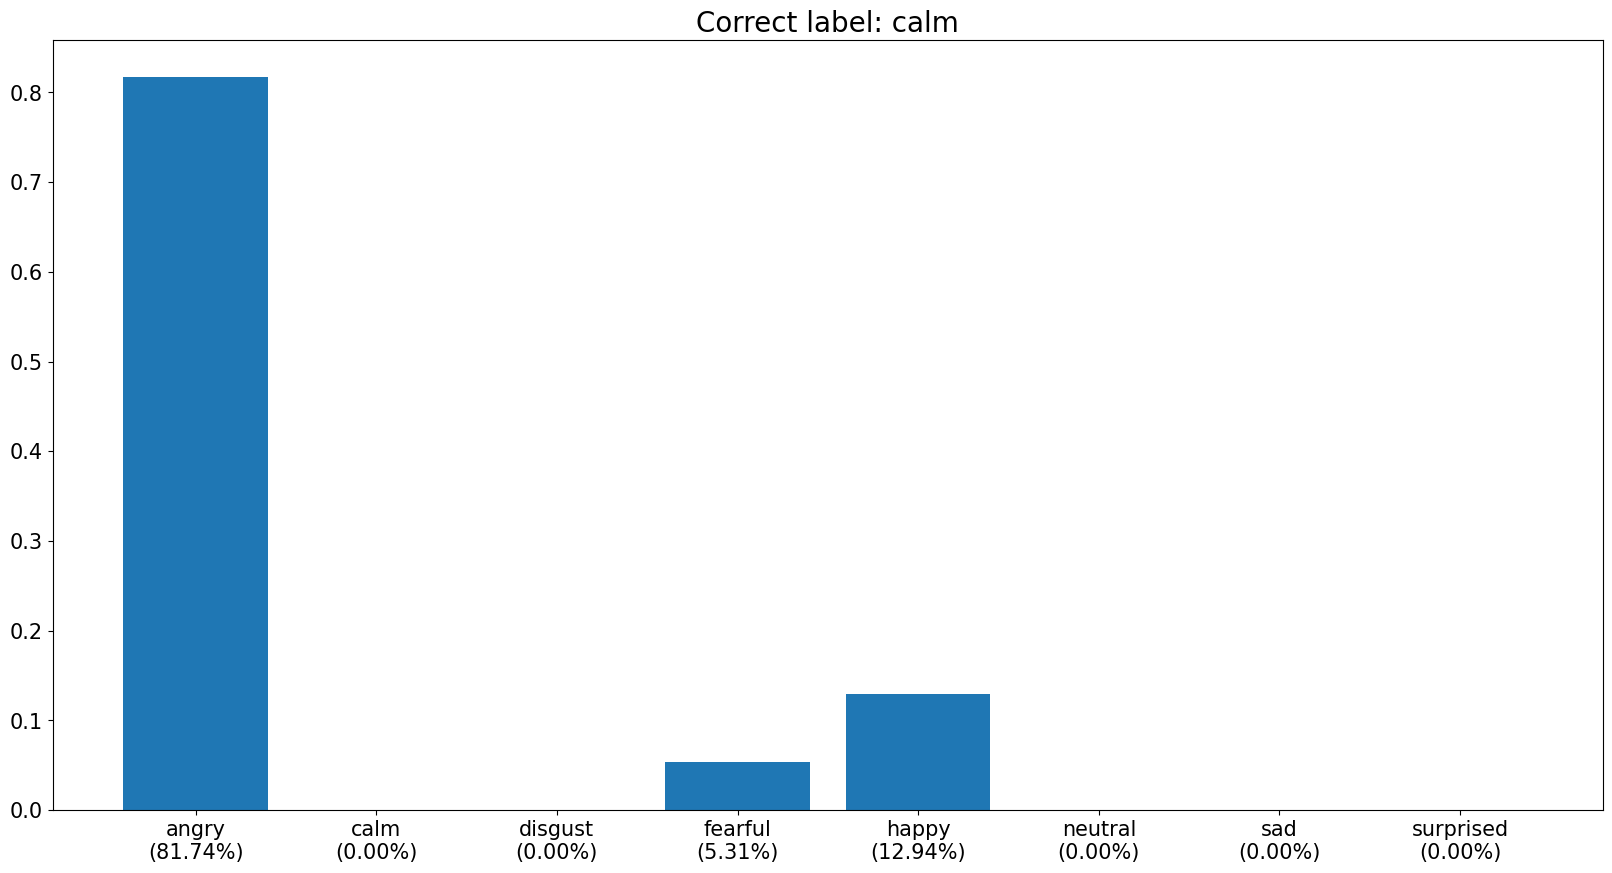

In [117]:
pred = export_res['predictions'][0].numpy()

valued_arr = []

for idx, name in enumerate(label_names):
    valued_arr.append(f'{name}\n({pred[idx]:.2%})')

fig = plt.subplots(figsize=(20, 10))
plt.bar(valued_arr, pred)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(f'Correct label: {label}', fontsize=20)

plt.show()

Save and reload the model, the reloaded model gives identical output:

In [118]:
E2E_model_path = Path(model_path, 'E2E/')
tf.saved_model.save(export, E2E_model_path)

Out:  (1, 90, 128, 1)
Out:  (None, 90, 128, 1)
INFO:tensorflow:Assets written to: Models\Speech\speech_model\Run_1\E2E\assets


In [119]:
imported = tf.saved_model.load((E2E_model_path))
imported_res = imported(audio_test_path)

In [120]:
a = imported_res['predictions'].numpy()
b = export_res['predictions'].numpy()

In [121]:
np.array_equal(a, b)

True